In [2]:
# This code downloads maximum or minimum daily temperature data from SMHI's OpenData API 
# Author: Marlon Passos
# Adapted from Kristoffer Bäckman https://github.com/thebackman/SMHI

In [387]:
# Meteorological Observations
ADR_VERSION   = "http://opendata-download-metobs.smhi.se/api/version/1.0.json"
ADR_PARAMETER = "http://opendata-download-metobs.smhi.se/api/version/1.0/parameter/{parameter}.json" 
ADR_STATION = "http://opendata-download-metobs.smhi.se/api/version/1.0/parameter/{parameter}/station/{station}.json"
ADR_LATEST_MONTHS = "http://opendata-download-metobs.smhi.se/api/version/1.0/parameter/{parameter}/station/{station}/period/latest-months/data.json"
ADR_CORRECTED = "http://opendata-download-metobs.smhi.se/api/version/1.0/parameter/{parameter}/station/{station}/period/corrected-archive/data.csv"

In [388]:
import datetime
import sys
import logging
import json
import requests

# -- logging

FORMAT = '%(asctime)s %(levelname)s: %(module)s: %(funcName)s(): %(message)s'
logging.basicConfig(level=logging.DEBUG, format = FORMAT, filename = "smhi.log", filemode = "w")
logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

# -- functions

def write_json(json_obj, file_name = 'file.json'):
    """ write a json file to wd/file.json"""
    with open(file_name, 'w') as outfile:
        json.dump(json_obj, outfile)

def api_return_data(adr):
    """ initate API call and return the JSON data """
    # initiate the call
    req_obj = requests.get(adr)
    # try to get the json data (exceptions will be catched later)
    json_data = req_obj.json()
    return json_data

In [389]:
import datetime
import sys
import logging
import json
import requests

# -- logging

FORMAT = '%(asctime)s %(levelname)s: %(module)s: %(funcName)s(): %(message)s'
logging.basicConfig(level=logging.DEBUG, format = FORMAT, filename = "smhi.log", filemode = "w")
logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

# -- functions

def write_json(json_obj, file_name = 'file.json'):
    """ write a json file to wd/file.json"""
    with open(file_name, 'w') as outfile:
        json.dump(json_obj, outfile)

def api_return_data(adr):
    """ initate API call and return the JSON data """
    # initiate the call
    req_obj = requests.get(adr)
    # try to get the json data (exceptions will be catched later)
    json_data = req_obj.json()
    return json_data
    

In [390]:
#import api_endpoints
#import helpers
import requests
import pandas as pd
import json
import logging

# -- functions

def list_params():
    """ Lists avaliable parameters """

    # -- API call

    data_json = api_return_data(ADR_VERSION)

    # -- print collected data

    # subset and loop over all avaliable parameters
    resource = data_json["resource"]
    # loop over the json entries and print each parameter that is avaliable

    # store all param keys in a dict for later use (maybe)
    params = []
    for param in resource:
        print(param["title"] + " | " +  param["summary"] + " | " + param["key"] )
        params.append(param["key"])
    # return params


def list_stations(param):
    """ list stations that have a certain wheather parameter """

    # -- API call
    
    # create the API adress
    adr = ADR_PARAMETER
    adr_full = adr.format(parameter = param)

    # send request and get data
    data1 = api_return_data(adr_full)
    print("Parameter choosen: " + data1["title"])

    # -- gather and wrangle the data about avaliable stations
    
    # take out an array with all the stations
    stations = data1["station"]
    
    # convert the JSON data to a pandas DF
    df_raw = pd.DataFrame(stations)
    
    # limit the data frame
    df_clean = df_raw[["name", "id", "height", "latitude", "longitude", "active", "from", "to", "updated", "title", "key"]]
    
    # rename columns to abide to python reserved keywords
    df_clean = df_clean.rename(columns={"from": "starting", "to": "ending"})
    
    # fix the date and time variables into something readable
    tmp1 = pd.to_datetime(df_clean["starting"], unit = "ms")
    tmp2 = pd.to_datetime(df_clean["ending"], unit = "ms")
    tmp3 = pd.to_datetime(df_clean["updated"], unit = "ms")
    df_clean = df_clean.assign(starting = tmp1)
    df_clean = df_clean.assign(ending = tmp2)
    df_clean = df_clean.assign(updated = tmp3)
    
    return(df_clean)


def get_latest_months(param, station):
    """
    get data for latest months via JSON download """

    # -- API call
    
    # create the API adress
    adr = ADR_LATEST_MONTHS
    adr_full = adr.format(parameter = param, station = station)
    
    # send request and get data
    data1 = api_return_data(adr_full)
    
    # create a data frame from the JSON data
    df = pd.DataFrame(data1["value"])

    # fix the timestamps
    df = df.rename(columns={"from": "starting", "to": "ending"})
    tmp1 = pd.to_datetime(df["starting"], unit = "ms")
    tmp2 = pd.to_datetime(df["ending"], unit = "ms")
    df = df.assign(starting = tmp1)
    df = df.assign(ending = tmp2)

    # convert value to float64
    df["value"] = df.value.astype(float)

    # add the station id
    df["station_id"] = station
    
    return df


def get_corrected(param, station):
    """ get corrected archive via CSV download """
    
    # -- API call
    
    # create the API adress
    adr = ADR_CORRECTED
    adr_full = adr.format(parameter = param, station = station)
    
    # download the csv data
    df = pd.read_csv(filepath_or_buffer= adr_full, skiprows= 9, delimiter=";")
       
    # remove columns not needed and reorder to match latest months data
    df_lim = df.iloc[:,[0, 4, 2, 1, 3]] 
        
    # rename the columns
    df_lim.columns = ["starting", "quality", "ref", "ending", "value"]
        
    # fix datetime columns
    tmp1 = pd.to_datetime(df_lim["starting"])
    tmp2 = pd.to_datetime(df_lim["ending"])
    df_lim = df_lim.assign(starting = tmp1)
    df_lim = df_lim.assign(ending = tmp2)

    
    # add the station id
    df_lim["station_id"] = station

    return df_lim


def get_stations(param, station_keys):
    """
    gets both latest months and corrected archive for
    a set of stations. Contains the try catch logic needed
    if any of the calls fail
    """

    # -- create the iterable

    if isinstance(station_keys, tuple):
        iterable = station_keys
    elif isinstance(station_keys, pd.DataFrame):
        iterable = station_keys["key"]
    
    # -- Construct some holder structures for data frames

    df_new = dict()
    df_old = dict()
    
    # -- loop through set of stations
    
    # start loop over each station id and collect the data if avaliable
    print(">>> Start downloading each station")
    for station_id in iterable:
        print(f">>> Downloading {station_id}")
        logging.info(f"# -- Downloading station {station_id}")
        # get the latest months
        logging.info(f"Downloading latest months for {station_id}")
        try:
            df_new[station_id] = get_latest_months(param = param, station = station_id )
            logging.debug(f"downloading latest months for {station_id} successful")
        except:
            logging.error(f"not possible to download latest months for {station_id}")
        # get the corrected archive
        logging.info(f"downloading corrected archive for {station_id}")
        try:
            df_old[station_id] = get_corrected(param = param, station = station_id)
            logging.debug(f"downloaded corrected archive for {station_id} successful")
        except Exception as error:
            logging.error(f"not possible to download corrected archive for {station_id}")
    
    # -- gather the data

    # get the number of data frames in each dict
    len_new = len(df_new)
    len_old = len(df_old)

    # Stack the latest months into one data frame for each station
    if len_new > 0:
        df_latest = pd.concat(df_new.values(), ignore_index=True)
    else:
        df_latest = None

    # Stack the corrected archive into one data frame for each station
    if len_old > 0:
        df_corrected = pd.concat(df_old.values(), ignore_index=True)
    else:
        df_corrected = None

    # return all data
    print("Check smhi.log for data download details!")
    if df_latest is not None and df_corrected is not None :
        logging.debug("both df_latest and df_corrected contains data")
        dictus = {"df_latest": df_latest, "df_corrected": df_corrected}
    elif df_latest is not None:
        logging.info("only df_latest contain data")
        dictus = {"df_latest": df_latest}
    elif df_corrected is not None:
        logging.info("only df_corrected contain data")
        dictus = {"df_corrected": df_corrected}
    else:
        logging.info("no data frame contains data")
        dictus = None
    
    # -- shutdown logging

    logging.shutdown()
    
    return(dictus)

In [391]:

# -- import the libs and some reload 

import pandas as pd
#import smhi as smhi
#import importlib
#importlib.reload(smhi)

# -- listing the parameters that are avaliable

params=list_params()

# -- for one parameter, see what stations have it and in what timeframe, lon lat area etc.
pnumber=19 # 5: daily precipitation, 20: max daily air temperature, 19: min daily air temperature

# all stations 
df_stations = list_stations(param = pnumber)

# list one station
df_stations.loc[df_stations["key"] == "159880"]

# limit the stations further to those that have been online in recent years
#df_stations = df_stations.loc[(df_stations["starting"] >= '2000-01-01')]

# take a random sample of stations
df_random = df_stations.sample(n = 10, random_state= 11)
df_random

station = (98210,)

# download for station(s)
dict_df = get_stations(param = pnumber, station_keys = station) 
#dict_df = get_stations(param = 5, station_keys = stations)

# access the data
#dict_df["df_latest"] # causing errors
dict_df["df_corrected"]

Byvind | max, 1 gång/tim | 21
Daggpunktstemperatur | momentanvärde, 1 gång/tim | 39
Global Irradians (svenska stationer) | medelvärde 1 timme, 1 gång/tim | 11
Lufttemperatur | medel, 1 gång per månad | 22
Lufttemperatur | min, 2 gånger per dygn, kl 06 och 18 | 26
Lufttemperatur | max, 2 gånger per dygn, kl 06 och 18 | 27
Lufttemperatur | min, 1 gång per dygn | 19
Lufttemperatur | momentanvärde, 1 gång/tim | 1
Lufttemperatur | medelvärde 1 dygn, 1 gång/dygn, kl 00 | 2
Lufttemperatur | max, 1 gång per dygn | 20
Lufttryck reducerat havsytans nivå | vid havsytans nivå, momentanvärde, 1 gång/tim | 9
Långvågs-Irradians | Långvågsstrålning, medel 1 timme, varje timme | 24
Markens tillstånd | momentanvärde, 1 gång/dygn, kl 06 | 40
Max av MedelVindhastighet | maximum av medelvärde 10 min, under 3 timmar, 1 gång/tim | 25
Molnbas | lägsta molnlager, momentanvärde, 1 gång/tim | 28
Molnbas | andra molnlager, momentanvärde, 1 gång/tim | 30
Molnbas | tredje molnlager, momentanvärde, 1 gång/tim | 32
M

,starting,quality,ref,ending,value,station_id
0,1881-12-31 20:00:01,G,1882-01-01,1882-01-01 20:00:00,-1.2,98210
1,1882-01-01 20:00:01,G,1882-01-02,1882-01-02 20:00:00,1.0,98210
2,1882-01-02 20:00:01,G,1882-01-03,1882-01-03 20:00:00,2.2,98210
3,1882-01-03 20:00:01,G,1882-01-04,1882-01-04 20:00:00,-1.0,98210
4,1882-01-04 20:00:01,G,1882-01-05,1882-01-05 20:00:00,-4.0,98210
...,...,...,...,...,...,...
51431,2022-10-26 18:00:01,Y,2022-10-27,2022-10-27 18:00:00,8.2,98210
51432,2022-10-27 18:00:01,Y,2022-10-28,2022-10-28 18:00:00,11.0,98210
51433,2022-10-28 18:00:01,Y,2022-10-29,2022-10-29 18:00:00,12.1,98210
51434,2022-10-29 18:00:01,Y,2022-10-30,2022-10-30 18:00:00,5.1,98210


In [392]:
import numpy as np
df_stations['duration']=df_stations['ending']-df_stations['starting']
df_stations['duration']=df_stations['duration']/ np.timedelta64(1, 'Y') # Convert from days to years
df_stations.sort_values(by='duration',ascending=False).head(30)

,name,id,height,latitude,longitude,active,starting,ending,updated,title,key,duration
642,Stockholm-Observatoriekullen,98210,43.133,59.3417,18.0549,True,1859-01-01,2023-02-04 10:00:00,2023-02-04 10:00:00,Lufttemperatur - Stockholm-Observatoriekullen,98210,164.094859
220,Halmstad,62400,24.000,56.6737,12.9242,False,1859-03-01,2020-06-30 23:59:59,2020-06-30 23:59:59,Lufttemperatur - Halmstad,62400,161.336646
819,Västerås,96350,15.836,59.5972,16.6001,True,1862-05-01,2023-02-04 10:00:00,2023-02-04 10:00:00,Lufttemperatur - Västerås,96350,160.765564
130,Falun-Lugnet,105370,161.395,60.6185,15.6574,True,1866-01-01,2023-02-04 10:00:00,2023-02-04 10:00:00,Lufttemperatur - Falun-Lugnet,105370,157.094031
228,Haparanda,163950,5.000,65.8367,24.1130,False,1862-02-01,2013-01-01 23:59:59,2013-01-01 23:59:59,Lufttemperatur - Haparanda,163950,150.918910
530,Piteå,161790,8.268,65.2625,21.4740,True,1872-04-01,2023-02-04 10:00:00,2023-02-04 10:00:00,Lufttemperatur - Piteå,161790,150.846127
768,Uppsala,97520,13.000,59.8585,17.6219,False,1840-01-01,1985-05-31 23:59:59,1985-05-31 23:59:59,Lufttemperatur - Uppsala,97520,145.415717
357,Kristianstad,64030,1.000,56.0221,14.1700,True,1878-05-01,2023-02-04 10:00:00,2023-02-04 10:00:00,Lufttemperatur - Kristianstad,64030,144.765236
272,Härnösand,127380,17.655,62.6364,17.9214,True,1879-04-01,2023-02-04 10:00:00,2023-02-04 10:00:00,Lufttemperatur - Härnösand,127380,143.848037
824,Växjö,64520,170.000,56.8427,14.8176,False,1863-09-01,2006-11-30 23:59:59,2006-11-30 23:59:59,Lufttemperatur - Växjö,64520,143.250032


In [ ]:
import pandas as pd
df_stations.to_excel('temp_stations.xlsx')
#df_stations=pd.read_excel('temp_stations.xlsx')
df_stations[df_stations['duration']>100]

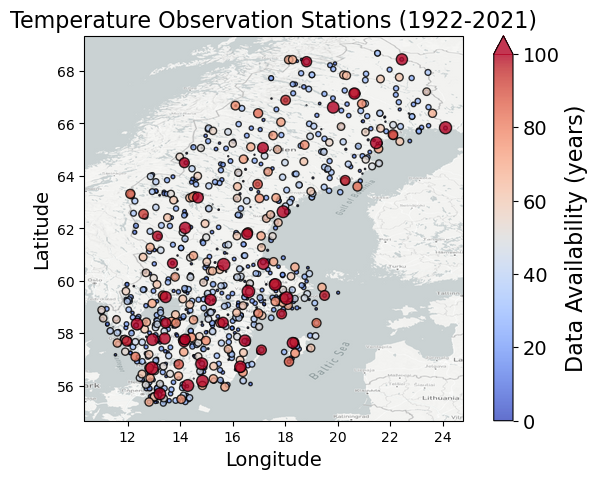

In [25]:
# Plot observation stations
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.io.shapereader import Reader
import numpy as np
import matplotlib
import matplotlib.colors as mcolors

# Sort your DataFrame
df_stations = df_stations.sort_values(by='duration')

plt.figure(figsize=(8, 5))

# Creates the map
sw_map = plt.axes(projection=ccrs.PlateCarree())

# To add county lines
mypath = r'C:\Users\MarlonVieiraPassos\OneDrive - SEI\Documents\HydroHazards\Codes\OSM\halmstad\data\shapefiles\\'
data = Reader(mypath + 'se_10km.shp')
sw_border = list(data.geometries())
sw_border2 = cfeature.ShapelyFeature(sw_border, ccrs.PlateCarree())
sw_map.add_feature(sw_border2, facecolor='none', edgecolor='gray')

request = cimgt.MapboxTiles(map_id='light-v10',access_token="pk.eyJ1IjoibXZwYXNzb3MiLCJhIjoiY2t6em4xcnpwMGJ2bDNicDYyemM0bWU4YyJ9.fR55BgEafulrz4yLfY2oRA")
sw_map.add_image(request, 5, cmap='gray', interpolation='spline36', regrid_shape=2000)

sw_map.xaxis.set_visible(True)
sw_map.yaxis.set_visible(True)

# Plots the data onto map
cmap = matplotlib.cm.coolwarm
norm = matplotlib.colors.Normalize(vmin=0, vmax=100)

plt.scatter(df_stations['longitude'], df_stations['latitude'], alpha=0.8,
            s=df_stations['duration'] / 2,
            c=df_stations['duration'],
            edgecolors='black',
            cmap=cmap,
            norm=norm,  # Apply the normalization to the scatter plot
            transform=ccrs.PlateCarree())

# Colorbar
cbar = plt.colorbar(extend='max')
cbar.set_label('Data Availability (years)', fontsize=16)
cbar.ax.tick_params(labelsize=14)
# Plot labels
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title('Temperature Observation Stations (1922-2021)', fontsize=16)

plt.savefig('temperature_stations_smhi2.png', format="png", dpi=120)
plt.show()


In [396]:
# Download data for all stations (air temperature)
pnumber = 19 # 20: average daily air temperature, 19: min daily temperature
df_all=pd.DataFrame()
id_list=df_stations['id'].unique()
for station_id in id_list:
    try:
        sid = (station_id,)
        dict_df = get_stations(param = pnumber, station_keys = sid) 
        df_all=df_all.append(dict_df["df_corrected"])
    except:
        pass

>>> Start downloading each station
>>> Downloading 154860
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 188800


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 188790


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 158990


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 85600


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 97280


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 92480
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 117330


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 178740


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 75040


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 99090


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 134590


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 53640


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 53390
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 178790
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 82000


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 73250


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 156990


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 74600


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 74510
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 144530


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 95230


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 167710


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 97390


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 53770
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 159880
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 92400


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 92410
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 97630


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 84660
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 94370
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 106070


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 84340


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 105550


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 97260


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 82540


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 97190


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 125470
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 74080


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 98040


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 98610


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 96610


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 136020


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 106080
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 116650


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 151290


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 151280


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 85160


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 53650


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 142030


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 163680


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 178820


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 83640


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 84900


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 155710


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 75140


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 92170


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 92130


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 132110


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 78050


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 161940


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 170630


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 155900


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 72400


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 54300


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 83170


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 105310


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 105280


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 105260


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 72450
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 138270


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 91130


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 96640
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 106040
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 92370


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 127130


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 161930


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 145450
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 82640
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 157870


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 78240


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 133030
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 150210


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 84620


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 62600
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 136610
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 123460


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 94390


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 115630
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 160600
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 73430
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 115040


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 156850


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 107120


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 94140


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 116480


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 116490


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 156770


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 156790
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 81320


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 91370
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 105640


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 75120


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 123060


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 96120


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 132240


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 116240


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 103050


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 132590


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 115230


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 115220


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 107440


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 53710
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 64330


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 66470


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 96140


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 98630


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 97370


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 82380


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 96230


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 96190


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 181970
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 98640
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 72120


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 107330


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 86090


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 62520


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 83090


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 52230


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 52240


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 105370


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 98620
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 162800


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 95320


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 94430


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 107140


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 107130


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 125020


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 118610


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 85410


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 122360


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 136491
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 74420
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 104390
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 96040
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 112510


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 106100


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 137080
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 93580


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 148050


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 148040


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 104090


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 126630
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 126300


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 63530


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 134130


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 151550


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 73390


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 84390


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 160750


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 160740


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 79580


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 78550


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 134410


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 134460


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 94410


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 82030


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 82110


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 63340


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 155790


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 73170
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 135640
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 76420
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 62550


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 159770


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 85450
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 89240


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 89230


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 127600


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 103290


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 72070


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 112170


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 108300


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 105050


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 105030


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 84610


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 82200


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 105360


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 95380


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 122610


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 145130


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 84690


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 147570


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 147560
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 76430


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 87360


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 98180


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 103090


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 103100


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 172740


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 106170


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 94600
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 144300
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 144310
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 180760


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 180740


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 125501
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 54650
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 106630
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 107400


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 107420
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 84520


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 74350


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 72630


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 71420


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 72420
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 74180
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 62260


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 135460


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 135440


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 62400


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 62390
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 62410
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 62420
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 54310


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 114410


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 62530
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 64020
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 163950


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 163960


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 170670


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 161780


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 180710


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 87150


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 87140


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 62080


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 123250


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 74410
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 123340


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 161650
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 62030
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 62040


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 155940


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 155970


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 155960


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 138400


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 138390


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 78140


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 85210


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 78250


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 73230


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 52560
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 68550
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 68560


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 86200


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 140360


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 140460


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 75520


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 146070


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 146050


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 117440


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 125450
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 125440


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 98290


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 74480


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 88590


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 89560


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 149700


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 149710


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 149160


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 83190


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 128370


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 127380


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 85180


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 97610
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 75380
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 63080


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 63160


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 81630


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 91520


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 62160


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 128560


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 145340


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 133050


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 95020


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 83610


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 91660
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 162970
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 53630


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 117370


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 102540


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 53530


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 105230


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 112540


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 147270


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 115460


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 169880


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 170860
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 62560


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 53250


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 143440


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 136420
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 136410
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 166810


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 126480


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 139260
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 133240


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 116430


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 74470


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 74460
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 74450


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 163940


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 66430
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 66420
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 168910


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 192830


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 192840
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 84310


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 64130
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 65090


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 93250


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 93230


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 93220


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 64040
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 139200
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 116720
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 188820
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 188850
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 189780


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 106160
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 85460


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 94190


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 75650


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 73610


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 180960


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 180940


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 155770


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 83670


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 154720
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 95530
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 95540
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 150640


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 124320
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 124300
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 63320


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 103570
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 82100
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 63610
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 86420
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 86650
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 182720
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 173960
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 145280
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 133500
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 65510


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 137040


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 106340
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 64030
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 54550
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 81150
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 94180
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 148300
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 82360
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 114330
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 136090
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 117430
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 149610
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 62190
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 85390
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 114270
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 95660
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 167980
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 167990
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 92630


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 72140
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 71510
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 85650
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 53480
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 98400
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 104600
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 96310
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 53270
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 71140
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 182930
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 167730
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 171790
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 87450
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 87440
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 83210


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 74640
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 192710
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 171770
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 171710
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 180770
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 146380
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 104120
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 105450
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 91620
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 65450


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 63670
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 83320
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 103600
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 114510
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 161810
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 95350
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 85250


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 85240
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 134180
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 63500
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 63510
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 63050
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 81130
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 126460
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 116500
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 122330
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 123070
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 74530
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 162870
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 162860
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 53430
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 53440
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 53460
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 128390
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 83460
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 148330
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 97240
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 83130
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 137110


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 188700
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 156730
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 127140
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 151220
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 53220
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 85040
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 85050
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 180750
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 53360
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 53370
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 52350
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 53300
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 103410


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 103420
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 158750
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 158740
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 85520
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 97170
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 65130
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 83440
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 63280


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 172920
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 155720


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 86330
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 96070
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 166910
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 166900
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 133630
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 104300
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 93360


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 73570
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 104580
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 77170
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 85330
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 73560
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 62130
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 144160
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 183980
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 170850
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 160790
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 93190
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 78320
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 75240
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 75250
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 81060


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 81050


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 66320
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 133190


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 74630


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 191900
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 191910
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 172680
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 170930
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 171920


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 83420
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 71190


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 179950
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 179960
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 167600
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 114630
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 95300
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 134090
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 81540


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 139340
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 128510
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 171780
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 86360
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 86350
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 86340
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 86370


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 157600
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 136270
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 98460
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 98510
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 145260
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 97160
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 149540
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 149560
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 97180
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 62140
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 86660
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 86480
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 87570
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 74390


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 78040
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 65080
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 74240
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 137070
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 76530
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 64170
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 162980
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 63220
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 52360
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 76160
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 87400
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 172940
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 183760
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 183750
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 182910
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 94450
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 149340
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 161710
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 161790
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 161770
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 169980
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 74440
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 171810
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 171820
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 136320


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 74490
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 169930
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 83280
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 189720
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 150090
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 95490
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 188830
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 72150
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 72160
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 64600
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 86570
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 108110
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 146150
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 177920
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 177930
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 150110
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 78310
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 78300
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 85010
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 65730
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 65160
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 72300


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 64620
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 75160
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 105200
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 73480
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 83630
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 162790
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 81040
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 112080
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 65360
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 98260
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 134150
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 116230
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 182810
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 96550
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 96560
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 159680
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 178680
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 107050
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 76000
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 54230
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 98170
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 72340
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 106360
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 54390
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 170920
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 178850
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 127220
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 135380
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 104530
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 63440
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 83050
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 86470
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 54330
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 63450
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 108100
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 64630
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 53660
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 83690
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 139110
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 139120
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 98100
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 83270
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 83620
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 83240
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 83200
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 83260
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 98160
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 66500
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 150450
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 151380
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 97750
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 54290
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 95500
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 53670
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 85280
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 74690
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 124390
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 63230
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 83230
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 53200
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 81220
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 84580
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 137100
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 97560
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 106060
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 157860
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 74340
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 88580
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 53720
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 86440
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 53540
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 154740
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 154730
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 116610
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 86670
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 96210
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 157720
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 54400
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 78360
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 167860
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 106270
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 97400
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 97200
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 98210
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 98230
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 77180
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 73090
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 178860
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 105220
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 133570
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 158850
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 112530
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 136360
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 113610
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 94320
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 146710
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 117610
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 149570
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 132620
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 132170
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 132180
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 98140
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 159600
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 146520
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 123480
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 122600
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 154710
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 163920
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 163900
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 74650
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 97270
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 96030
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 81560
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 135520
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 94580
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 94660
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 159970
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 170790
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 161680
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 136640
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 127240
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 127310
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 93520
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 93340
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 115050
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 53560
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 98490
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 84780
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 181890
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 81340
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 66460
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 97220
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 53780
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 124020
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 124030
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 99330
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 99270
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 99280
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 140200
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 132030
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 81010
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 52660
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 92100
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 113100
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 113410
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 113420
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 105210
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 71470
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 71500
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 105410
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 64390
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 82260
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 82250
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 99450
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 97730
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 117170
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 117160
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 97120
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 127630
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 113110
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 178970
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 53580
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 137560
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 84630
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 73660
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 64320
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 169790
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 96480
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 74300
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 188840
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 189760
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 126290
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 103080
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 71430
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 63600
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 63590
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 76380
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 84020
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 85020
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 53230
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 133160
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 53510
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 82620
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 82190
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 87540
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 71360
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 113230
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 97100
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 86010
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 122260
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 155910
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 72520
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 81210
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 54580
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 72090
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 128590
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 73470
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 135500
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 97490
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 97210
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 147460
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 114360
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 140500
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 140480
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 140490
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 108170
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 133200
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 65020
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 107270
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 97520
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 97510
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 97530
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 81640
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 64290
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 151640
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 64400
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 55570
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 95640
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 107450
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 88570
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 78030
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 86130
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 96000
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 72080
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 93240
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 105630
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 188810
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 52550
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 75630
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 160960
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 160970
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 137030
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 146350
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 94170
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 75400
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 156940
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 157930
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 149120
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 71380
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 95030
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 106500
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 78390
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 78400
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 84060
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 84050
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 65310
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 181900
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 166870
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 98590
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 81350
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 81620
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 82230
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 97620
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 139540
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 98200
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 107180
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 150270
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 85270
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 83340
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 76470
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 96350
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 96370
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 138070
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 107530
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 85630
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 64520
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 64510
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 64560
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 82010
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 73190
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 52620
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 97070
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 173900
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 53260
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 124110
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 147170
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 85490
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 84470
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 114160
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 114140
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 161690
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 161910
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 62710
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 62180
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 97150
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 83540
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 97700
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 179740
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 134620
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 134520
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 106570
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 106580
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 92030
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 151600
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 133230
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 133260
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 92380
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 75100
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 147100
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 147090
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 94050
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 85130
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 82650
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 85220
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 161800
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 87520
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 77220
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 77210
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 66040
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 66120
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 66110
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 66630
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 84260
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 72290
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 95160
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 95170
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 95130
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 108640
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 52510
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 138240
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 108320
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 53470
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 78280
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 134100
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 134110
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 102190
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 102200
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 102210
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 102170
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 172790
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 172770
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 173810
Check smhi.log for data download details!
>>> Start downloading each station
>>> Downloading 133470
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


>>> Start downloading each station
>>> Downloading 86700
Check smhi.log for data download details!


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_8500\3869588013.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(dict_df["df_corrected"])


In [397]:
#df_all.to_csv('mintemp_data.csv')

In [438]:
df_stations

,name,id,height,latitude,longitude,active,starting,ending,updated,title,key,duration
0,Abelvattnet Aut,154860,665.000,65.5300,14.9700,False,1985-05-01,1996-08-31 23:59:59,1996-08-31 23:59:59,Lufttemperatur - Abelvattnet Aut,154860,11.337673
1,Abisko,188800,393.380,68.3538,18.8166,False,1913-01-01,2018-12-31 23:59:59,2018-12-31 23:59:59,Lufttemperatur - Abisko,188800,106.000808
2,Abisko Aut,188790,392.303,68.3538,18.8164,True,1985-06-01,2023-02-04 10:00:00,2023-02-04 10:00:00,Lufttemperatur - Abisko Aut,188790,37.680217
3,Abraur,158990,368.079,65.9857,18.9195,True,1991-07-01,2022-12-31 23:59:59,2022-12-31 23:59:59,Lufttemperatur - Abraur,158990,31.505096
4,Adelsnäs,85600,97.000,58.1998,15.9802,False,1945-01-01,1960-12-31 23:59:59,1960-12-31 23:59:59,Lufttemperatur - Adelsnäs,85600,16.000329
...,...,...,...,...,...,...,...,...,...,...,...,...
888,Överkalix-Svartbyn,172790,46.000,66.2646,22.8365,False,1962-08-01,1995-11-30 23:59:59,1995-11-30 23:59:59,Lufttemperatur - Överkalix-Svartbyn,172790,33.334018
889,Överkalix-Svartbyn A,172770,61.024,66.2618,22.8427,True,1995-12-01,2023-02-04 10:00:00,2023-02-04 10:00:00,Lufttemperatur - Överkalix-Svartbyn A,172770,27.180344
890,Övertorneå,173810,59.508,66.3860,23.6155,True,1955-01-01,2023-02-04 10:00:00,2023-02-04 10:00:00,Lufttemperatur - Övertorneå,173810,68.095626
891,Överäng,133470,450.000,63.7788,13.0734,False,1966-12-01,2006-02-28 23:59:59,2006-02-28 23:59:59,Lufttemperatur - Överäng,133470,39.247897


In [143]:
import pandas as pd
#df_all=pd.read_csv('maxtemp_data.csv')
df_all=pd.read_csv('maxtemp_data.csv')

In [144]:
# Sort by date 
df_all = df_all.dropna(subset=['value'])
df_all=df_all.sort_values(by='ref')
df_all.ref=pd.to_datetime(df_all.ref)

In [59]:
df_all

,Unnamed: 0,starting,quality,ref,ending,value,station_id
6449030,0,1839-12-31 20:00:01,G,1840-01-01,1840-01-01 20:00:00,-5.9,97520
6449031,1,1840-01-01 20:00:01,G,1840-01-02,1840-01-02 20:00:00,-4.3,97520
6449032,2,1840-01-02 20:00:01,G,1840-01-03,1840-01-03 20:00:00,-3.3,97520
6449033,3,1840-01-03 20:00:01,G,1840-01-04,1840-01-04 20:00:00,-3.8,97520
6449034,4,1840-01-04 20:00:01,G,1840-01-05,1840-01-05 20:00:00,-7.8,97520
...,...,...,...,...,...,...,...
4797342,15482,2022-09-29 18:00:01,Y,2022-09-30,2022-09-30 18:00:00,9.5,162790
6185526,5308,2022-09-29 18:00:01,Y,2022-09-30,2022-09-30 18:00:00,14.1,63590
43618,10853,2022-09-29 18:00:01,G,2022-09-30,2022-09-30 18:00:00,5.4,158990
6508235,26203,2022-09-29 18:00:01,Y,2022-09-30,2022-09-30 18:00:00,12.4,97530


In [145]:
#df_stations.to_excel('mintemp_stations.xlsx')
df_stations=pd.read_excel('maxtemp_stations.xlsx')
df_all = df_all.dropna(subset=['value'])
df_all=df_all.sort_values(by='ref')
df_all.ref=pd.to_datetime(df_all.ref)
# Extract last 100 years of data from 1922 to 2022
df_all=df_all[df_all['ref']>='1922-01-01']
df_all=df_all[df_all['ref']<'2022-01-01']

In [133]:
df_all

,Unnamed: 0,starting,quality,ref,ending,value,station_id
4721316,6361,1921-12-31 20:00:01,G,1922-01-01,1922-01-01 20:00:00,-21.0,188830
2719737,14604,1921-12-31 20:00:01,G,1922-01-01,1922-01-01 20:00:00,-5.0,74470
3508029,14593,1921-12-31 20:00:01,G,1922-01-01,1922-01-01 20:00:00,-6.0,85250
5747207,9142,1921-12-31 20:00:01,G,1922-01-01,1922-01-01 20:00:00,-7.0,132620
5585116,14607,1921-12-31 20:00:01,G,1922-01-01,1922-01-01 20:00:00,-5.0,98210
...,...,...,...,...,...,...,...
3225765,15686,2021-12-30 18:00:01,Y,2021-12-31,2021-12-31 18:00:00,-3.3,117430
2614402,7589,2021-12-30 18:00:01,Y,2021-12-31,2021-12-31 18:00:00,-11.2,170860
6785163,19820,2021-12-30 18:00:01,G,2021-12-31,2021-12-31 18:00:00,-12.5,160960
637426,50363,2021-12-30 18:00:01,Y,2021-12-31,2021-12-31 18:00:00,5.2,72450
